In [ ]:
import cv2
import numpy as np

# 7-segment digit pattern lookup table
DIGIT_LOOKUP = {
    (1, 1, 1, 0, 1, 1, 1): 0,
    (0, 0, 1, 0, 0, 1, 0): 1,
    (1, 0, 1, 1, 1, 0, 1): 2,
    (1, 0, 1, 1, 0, 1, 1): 3,
    (0, 1, 1, 1, 0, 1, 0): 4,
    (1, 1, 0, 1, 0, 1, 1): 5,
    (1, 1, 0, 1, 1, 1, 1): 6,
    (1, 0, 1, 0, 0, 1, 0): 7,
    (1, 1, 1, 1, 1, 1, 1): 8,
    (1, 1, 1, 1, 0, 1, 1): 9
}

# Load image
image = cv2.imread('digit.jpg')
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Create a mask for blue color (7-segment display)
lower_blue = np.array([100, 100, 100])
upper_blue = np.array([140, 255, 255])
mask = cv2.inRange(hsv, lower_blue, upper_blue)

# Optional: clean up mask
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Find contours in the mask
contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
digit_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 150]
digit_contours = sorted(digit_contours, key=lambda cnt: cv2.boundingRect(cnt)[0])

result = ""

for cnt in digit_contours:
    x, y, w, h = cv2.boundingRect(cnt)
    roi = mask[y:y+h, x:x+w]
    roi = cv2.resize(roi, (100, 150))

    segments = [
        ((15, 0), (85, 20)),     # top
        ((80, 0), (100, 75)),    # top-right
        ((80, 75), (100, 150)),  # bottom-right
        ((15, 130), (85, 150)),  # bottom
        ((0, 75), (20, 150)),    # bottom-left
        ((0, 0), (20, 75)),      # top-left
        ((15, 65), (85, 85))     # center
    ]

    on = []
    for (xa, ya), (xb, yb) in segments:
        seg_roi = roi[ya:yb, xa:xb]
        area = (xb - xa) * (yb - ya)
        total = cv2.countNonZero(seg_roi)
        on.append(1 if total / float(area) > 0.3 else 0)

    digit = DIGIT_LOOKUP.get(tuple(on), '?')
    result += str(digit)

    # Visual debug
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, str(digit), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# Show results
print(f"Detected Digits: {result}")
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f'Detected Digits: {result}')
plt.axis('off')
plt.show()

Detected Digits: ?8


In [ ]:
import cv2
import numpy as np
import pytesseract

# Set Tesseract path
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Load original image
image = cv2.imread('digit.jpg')

# Convert to HSV and mask blue light
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower_blue = np.array([100, 100, 100])
upper_blue = np.array([140, 255, 255])
mask = cv2.inRange(hsv, lower_blue, upper_blue)

# Morphological clean-up
kernel = np.ones((3, 3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

# Find contours in the mask
contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter and get bounding boxes
digit_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 100]
if not digit_contours:
    print("No digit contours found.")
    exit()

# Combine bounding boxes to extract digit area
x_min = min([cv2.boundingRect(c)[0] for c in digit_contours])
y_min = min([cv2.boundingRect(c)[1] for c in digit_contours])
x_max = max([cv2.boundingRect(c)[0] + cv2.boundingRect(c)[2] for c in digit_contours])
y_max = max([cv2.boundingRect(c)[1] + cv2.boundingRect(c)[3] for c in digit_contours])

# Add padding to the cropped box
pad = 5
x_min = max(x_min - pad, 0)
y_min = max(y_min - pad, 0)
x_max = min(x_max + pad, image.shape[1])
y_max = min(y_max + pad, image.shape[0])

# Crop digit region
roi = image[y_min:y_max, x_min:x_max]

# Preprocess for OCR
gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
inv = cv2.bitwise_not(gray)
thresh = cv2.threshold(inv, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# OCR
config = r'--psm 7 -c tessedit_char_whitelist=-0123456789'
text = pytesseract.image_to_string(thresh, config=config).strip()

# Show results
print(f"Detected Digits: {text}")
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
axes[0].set_title('Digit Area')
axes[0].axis('off')
axes[1].imshow(thresh, cmap='gray')
axes[1].set_title('Preprocessed for OCR')
axes[1].axis('off')
fig.suptitle(f'Detected Digits: {text}')
plt.tight_layout()
plt.show()

Detected Digits: 


In [3]:
import cv2
import pytesseract

# Set Tesseract path
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Load image
image = cv2.imread('digit.jpg')  # Or use full path if not in same folder

# Convert to grayscale and invert
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
inv = cv2.bitwise_not(gray)

# OCR with whitelist for digits and minus
text = pytesseract.image_to_string(inv, config='--psm 7 -c tessedit_char_whitelist=-0123456789')

print(f"Detected: {text.strip()}")


Detected: 


In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy

In [ ]:
import cv2
import numpy as np

image = cv2.imread("digit.jpg")

blue_points = np.array([
    [430, 459],
    [1413, 461],
    [1413, 1092],
    [430, 1092]
], dtype=np.float32)

# Define output size (you can adjust these)
width, height = 160, 80
dst_points = np.array([
    [0, 0],
    [width - 1, 0],
    [width - 1, height - 1],
    [0, height - 1]
], dtype=np.float32)

# Apply perspective transform
matrix = cv2.getPerspectiveTransform(blue_points, dst_points)
warped = cv2.warpPerspective(image, matrix, (width, height))

cv2.imwrite("warped_blue_digits.jpg", warped)


True

In [5]:
import cv2
import numpy as np

image = cv2.imread("camera_2.jpg")

blue_points = np.array([
    [919, 268],
    [1800, 268],
    [1800, 870],
    [919, 870]
], dtype=np.float32)

# Define output size (you can adjust these)
width, height = 160, 80
dst_points = np.array([
    [0, 0],
    [width - 1, 0],
    [width - 1, height - 1],
    [0, height - 1]
], dtype=np.float32)

# Apply perspective transform
matrix = cv2.getPerspectiveTransform(blue_points, dst_points)
warped = cv2.warpPerspective(image, matrix, (width, height))

cv2.imwrite("warped_blue_digits2.jpg", warped)


True

Detected Digits: ['-', 2, 3]
Final Value: -23.0


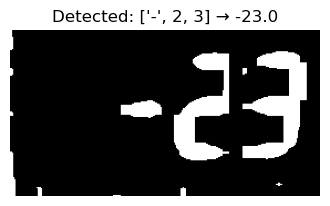

In [6]:
import cv2
import numpy as np
from imutils import contours

# Lookup table for 7-segment digits
DIGITS_LOOKUP = {
    (1, 1, 1, 0, 1, 1, 1): 0,
    (0, 0, 1, 0, 0, 1, 0): 1,
    (1, 0, 1, 1, 1, 0, 1): 2,
    (1, 0, 1, 1, 0, 1, 1): 3,
    (0, 1, 1, 1, 0, 1, 0): 4,
    (1, 1, 0, 1, 0, 1, 1): 5,
    (1, 1, 0, 1, 1, 1, 1): 6,
    (1, 0, 1, 0, 0, 1, 0): 7,
    (1, 1, 1, 1, 1, 1, 1): 8,
    (1, 1, 1, 1, 0, 1, 1): 9,
}

# Perspective points (example)
blue_points = np.array([
    [430, 459],
    [1500, 461],
    [1500, 1092],
    [430, 1092]
], dtype=np.float32)


# Resize image with aspect ratio preserved
def resize_image_to_fit(image, max_width, max_height):
    height, width = image.shape[:2]
    ratio = min(max_width / width, max_height / height)
    new_dimensions = (int(width * ratio), int(height * ratio))
    resized = cv2.resize(image, new_dimensions, interpolation=cv2.INTER_CUBIC)
    return new_dimensions, resized

# Add vertical padding between digits
def add_padding(img, pad_width, pad_value=0):
    height = img.shape[0]
    padding = np.full((height, pad_width), pad_value, dtype=img.dtype)
    return np.hstack((img, padding))

# Preprocessing for blue display
def preprocess_blue_image(image, new_dimension):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Crop 3 digit regions
    #cropped1 = thresholded[:, 0:100]
    #cropped2 = thresholded[:, 110:210]
    #cropped3 = thresholded[:, 215:315]

    x, y, w, h = 0, 0, 100, new_dimension[1]
    cropped1 = thresholded[y:y + h, x:x + w]
    x, y, w, h = 110, 0, 100, new_dimension[1]
    cropped2 = thresholded[y:y + h, x:x + w]
    x, y, w, h = 215, 0, 60, new_dimension[1]
    cropped3 = thresholded[y:y + h, x:x + w]

    # Morphological cleaning
    closing1 = cv2.morphologyEx(cropped1, cv2.MORPH_CLOSE, np.ones((12, 12), np.uint8))
    dilate2 = cv2.dilate(cropped2, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)), iterations=2)
    closing2 = cv2.morphologyEx(dilate2, cv2.MORPH_CLOSE, np.ones((12, 12), np.uint8))
    dilate3 = cv2.dilate(cropped3, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)), iterations=2)
    closing3 = cv2.morphologyEx(dilate3, cv2.MORPH_CLOSE, np.ones((12, 12), np.uint8))

    # Pad and merge
    closing2 = add_padding(closing2, 10)
    closing3 = add_padding(closing3, 10)
    erode2 = cv2.erode(closing2, np.ones((5, 5), np.uint8), iterations=1)
    erode3 = cv2.erode(closing3, np.ones((5, 5), np.uint8), iterations=1)

    return np.hstack((closing1, erode2, erode3))

# Recognize digits
def find_blue_digit_contour(image):
    cnts, _ = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    digits = []
    digits_cnts = []

    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        if h < w / 2 and h < 60 and w * h > 200:
            digits.append('-')
        elif w * h > 1000:
            digits_cnts.append(c)

    digits_cnts = contours.sort_contours(digits_cnts, method="left-to-right")[0]

    for c in digits_cnts:
        x, y, w, h = cv2.boundingRect(c)
        roi = image[y:y + h, x:x + w]
        roiH, roiW = roi.shape

        if roiW < roiH / 3:
            digits.append(1)
            continue

        (dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
        dHC = int(roiH * 0.05)
        segments = [
            ((dW, 0), (w - dW, dH)),  # top
            ((int(0.5 * dW), 0), (dW, h // 2)),  # top-left
            ((w - dW, 0), (w, h // 2)),  # top-right
            ((dW, (h // 2) - dHC), (w - dW, (h // 2) + dHC)),  # center
            ((0, h // 2), (dW, h)),  # bottom-left
            ((w - int(1.5 * dW), h // 2), (w - dW, h)),  # bottom-right
            ((0, h - dH), (w - dW, h))  # bottom
        ]

        on = [0] * 7
        for i, ((xA, yA), (xB, yB)) in enumerate(segments):
            segROI = roi[yA:yB, xA:xB]
            total = cv2.countNonZero(segROI)
            area = (xB - xA) * (yB - yA)
            if total / float(area) > 0.5:
                on[i] = 1

        digit = DIGITS_LOOKUP.get(tuple(on), '?')
        digits.append(digit)

    return digits

# Convert digit list to float (e.g. ['-', 1, 2, 3] → -123.0)
def list_to_float(digit_list):
    digit_str = ''.join(str(d) for d in digit_list)
    try:
        return float(digit_str)
    except ValueError:
        print("Failed to convert:", digit_str)
        return None

# MAIN FUNCTION
def blue_main(image_path):
    image = cv2.imread(image_path)
    
    # Perspective transform
    pts_dst = np.array([[0, 0], [100, 0], [100, 50], [0, 50]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(blue_points, pts_dst)
    warped = cv2.warpPerspective(image, M, (100, 50))

    # Resize & process
    dimensions, resized = resize_image_to_fit(warped, 300, 300)
    processed = preprocess_blue_image(resized, dimensions)

    # Recognize digits
    digits = find_blue_digit_contour(processed)
    result = list_to_float(digits)
    print("Detected Digits:", digits)
    print("Final Value:", result)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(4, 3))
    plt.imshow(processed, cmap='gray')
    plt.title(f'Detected: {digits} → {result}')
    plt.axis('off')
    plt.show()

# Example usage
blue_main("digit.jpg")


Detected Digits: ['-', 1, 4]
Final Value: -14.0


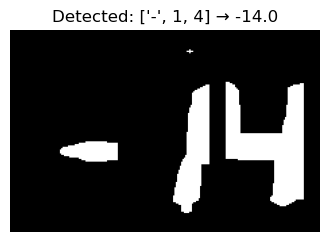

In [5]:
import cv2
import numpy as np
from imutils import contours

# Lookup table for 7-segment digits
DIGITS_LOOKUP = {
    (1, 1, 1, 0, 1, 1, 1): 0,
    (0, 0, 1, 0, 0, 1, 0): 1,
    (1, 0, 1, 1, 1, 0, 1): 2,
    (1, 0, 1, 1, 0, 1, 1): 3,
    (0, 1, 1, 1, 0, 1, 0): 4,
    (1, 1, 0, 1, 0, 1, 1): 5,
    (1, 1, 0, 1, 1, 1, 1): 6,
    (1, 0, 1, 0, 0, 1, 0): 7,
    (1, 1, 1, 1, 1, 1, 1): 8,
    (1, 1, 1, 1, 0, 1, 1): 9,
}

# Perspective points (example)
blue_points = np.array([
    [919, 268],
    [1800, 268],
    [1800, 870],
    [919, 870]
], dtype=np.float32)


# Resize image with aspect ratio preserved
def resize_image_to_fit(image, max_width, max_height):
    height, width = image.shape[:2]
    ratio = min(max_width / width, max_height / height)
    new_dimensions = (int(width * ratio), int(height * ratio))
    resized = cv2.resize(image, new_dimensions, interpolation=cv2.INTER_CUBIC)
    return new_dimensions, resized

# Add vertical padding between digits
def add_padding(img, pad_width, pad_value=0):
    height = img.shape[0]
    padding = np.full((height, pad_width), pad_value, dtype=img.dtype)
    return np.hstack((img, padding))

# Preprocessing for blue display
def preprocess_blue_image(image, new_dimension):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Crop 3 digit regions
    #cropped1 = thresholded[:, 0:100]
    #cropped2 = thresholded[:, 110:210]
    #cropped3 = thresholded[:, 215:315]

    x, y, w, h = 0, 0, 80, new_dimension[1]
    cropped1 = thresholded[y:y + h, x:x + w]
    x, y, w, h = 110, 0, 70, new_dimension[1]
    cropped2 = thresholded[y:y + h, x:x + w]
    x, y, w, h = 195, 0, 60, new_dimension[1]
    cropped3 = thresholded[y:y + h, x:x + w]

    # Morphological cleaning
    closing1 = cv2.morphologyEx(cropped1, cv2.MORPH_CLOSE, np.ones((12, 12), np.uint8))
    dilate2 = cv2.dilate(cropped2, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)), iterations=2)
    closing2 = cv2.morphologyEx(dilate2, cv2.MORPH_CLOSE, np.ones((12, 12), np.uint8))
    dilate3 = cv2.dilate(cropped3, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)), iterations=2)
    closing3 = cv2.morphologyEx(dilate3, cv2.MORPH_CLOSE, np.ones((12, 12), np.uint8))

    # Pad and merge
    closing2 = add_padding(closing2, 10)
    closing3 = add_padding(closing3, 10)
    erode2 = cv2.erode(closing2, np.ones((5, 5), np.uint8), iterations=1)
    erode3 = cv2.erode(closing3, np.ones((5, 5), np.uint8), iterations=1)

    return np.hstack((closing1, erode2, erode3))

# Recognize digits
def find_blue_digit_contour(image):
    cnts, _ = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    digits = []
    digits_cnts = []

    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        if h < w / 2 and h < 60 and w * h > 200:
            digits.append('-')
        elif w * h > 1000:
            digits_cnts.append(c)

    digits_cnts = contours.sort_contours(digits_cnts, method="left-to-right")[0]

    for c in digits_cnts:
        x, y, w, h = cv2.boundingRect(c)
        roi = image[y:y + h, x:x + w]
        roiH, roiW = roi.shape

        if roiW < roiH / 3:
            digits.append(1)
            continue

        (dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
        dHC = int(roiH * 0.05)
        segments = [
            ((dW, 0), (w - dW, dH)),  # top
            ((int(0.5 * dW), 0), (dW, h // 2)),  # top-left
            ((w - dW, 0), (w, h // 2)),  # top-right
            ((dW, (h // 2) - dHC), (w - dW, (h // 2) + dHC)),  # center
            ((0, h // 2), (dW, h)),  # bottom-left
            ((w - int(1.5 * dW), h // 2), (w - dW, h)),  # bottom-right
            ((0, h - dH), (w - dW, h))  # bottom
        ]

        on = [0] * 7
        for i, ((xA, yA), (xB, yB)) in enumerate(segments):
            segROI = roi[yA:yB, xA:xB]
            total = cv2.countNonZero(segROI)
            area = (xB - xA) * (yB - yA)
            if total / float(area) > 0.5:
                on[i] = 1

        digit = DIGITS_LOOKUP.get(tuple(on), '?')
        digits.append(digit)

    return digits

# Convert digit list to float (e.g. ['-', 1, 2, 3] → -123.0)
def list_to_float(digit_list):
    digit_str = ''.join(str(d) for d in digit_list)
    try:
        return float(digit_str)
    except ValueError:
        print("Failed to convert:", digit_str)
        return None

# MAIN FUNCTION
def blue_main(image_path):
    image = cv2.imread(image_path)
    
    # Perspective transform
    pts_dst = np.array([[0, 0], [100, 0], [100, 50], [0, 50]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(blue_points, pts_dst)
    warped = cv2.warpPerspective(image, M, (100, 50))

    # Resize & process
    dimensions, resized = resize_image_to_fit(warped, 300, 300)
    processed = preprocess_blue_image(resized, dimensions)

    # Recognize digits
    digits = find_blue_digit_contour(processed)
    result = list_to_float(digits)
    print("Detected Digits:", digits)
    print("Final Value:", result)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(4, 3))
    plt.imshow(processed, cmap='gray')
    plt.title(f'Detected: {digits} → {result}')
    plt.axis('off')
    plt.show()

# Example usage
blue_main("camera_2.jpg")


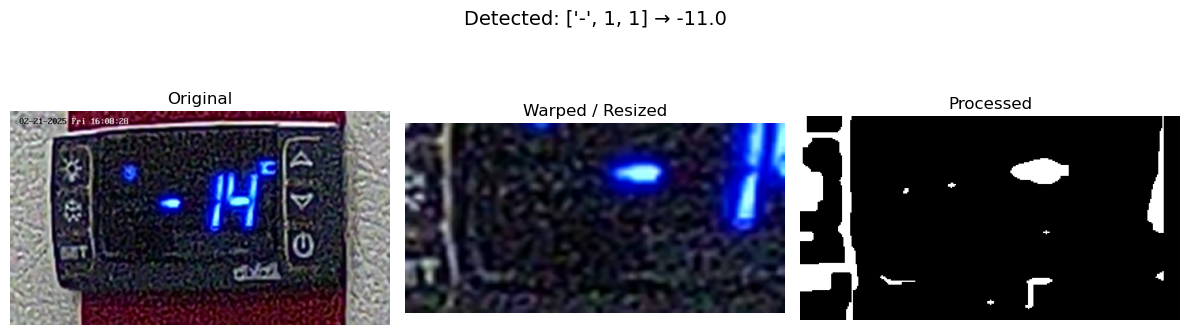

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Visualize using matplotlib instead of cv2.imshow
image_path = 'camera_2.jpg'  # change to 'digit.jpg' if desired

# Perspective transform (uses blue_points and helper funcs defined above)
image = cv2.imread(image_path)
pts_dst = np.array([[0, 0], [100, 0], [100, 50], [0, 50]], dtype=np.float32)
M = cv2.getPerspectiveTransform(blue_points, pts_dst)
warped = cv2.warpPerspective(image, M, (100, 50))

# Resize & preprocess
new_dims, resized = resize_image_to_fit(warped, 300, 300)
processed = preprocess_blue_image(resized, new_dims)

# Recognize digits
digits = find_blue_digit_contour(processed)
value = list_to_float(digits)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
axes[1].set_title('Warped / Resized')
axes[1].axis('off')

axes[2].imshow(processed, cmap='gray')
axes[2].set_title('Processed')
axes[2].axis('off')

fig.suptitle(f'Detected: {digits} → {value}', fontsize=14)
plt.tight_layout()
plt.show()
